In [1]:
# Data
import yfinance as yf
import yahooquery 

# Maths
import numpy as np
import pandas as pd
from scipy.optimize import minimize, differential_evolution
from scipy import stats
from statsmodels.tsa.stattools import coint

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Data handling
import pandas_datareader as pdr
import pandas_market_calendars as mcal

# Utility
import datetime

In [2]:
def Get_top_10_ETF_symbols(ETF):
    holdings = yahooquery.Ticker(ETF).fund_holding_info[ETF]['holdings']
    return [holding['symbol'] for holding in holdings]
def Get_ETF_data(ETF):
    tickers = Get_top_10_ETF_symbols(ETF)
    df = yf.download(tickers, start=valid_start_day)['Open']
    df = df.dropna(axis=1, how='any')
    return df

In [3]:
# Date and Time
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=365)
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

# List of ETF: https://en.wikipedia.org/wiki/List_of_American_exchange-traded_funds 

#SMH_top_10_tickers = Get_top_10_ETF_symbols('SMH') # VanEck Semiconductor ETF
#AMLP_top_10_tickers = Get_top_10_ETF_symbols('AMLP') # energy, ALPS Alerian MLP ETF
#VDE_top_10_tickers = Get_top_10_ETF_symbols('VDE') # Vanguard Energy
#XLF_top_10_tickers = Get_top_10_ETF_symbols('XLF') # Financial Select Sector SPDR
#VOO_top_10_tickers = Get_top_10_ETF_symbols('VOO') # Vanguard S&P 500 ETF

# Download data
df = Get_ETF_data('XOP')

[*********************100%%**********************]  10 of 10 completed


In [4]:
# Split data
def Log_return(df): # We use log return as the time series instead of the stock itself (got more nicer properties!)
    return np.log(df/df.shift(1)).dropna()
TT_split = 0.95 #you need constant update so Train-test split must be large to see good result

Train_df = df[:int(len(df)*TT_split)]
Train_df_return = Log_return(Train_df)

Test_df = df[int(len(df)*TT_split):]

In [5]:
def find_cointegrated_pairs(df):
    n = df.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = df.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = df[keys[i]]
            S2 = df[keys[j]]
            result = coint(S1, S2) # return: Test Statistic, P-value, Critical Values
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.01:
                pairs.append([keys[i], keys[j]])
    return score_matrix, pvalue_matrix, pairs

def calculate_spread_zscore(pair, df, window):
    stock1 = df[pair[0]]
    stock2 = df[pair[1]]
    spread = stock1 - stock2
    zscore = (spread - spread.rolling(window=window).mean()) / spread.rolling(window=window).std()
    return zscore

In [6]:
# Calculate rolling z
z_score_window = 20

# Find cointegrated pairs
score_matrix, pvalue_matrix, cointegrated_pairs = find_cointegrated_pairs(Train_df_return)

print(f"Found {len(cointegrated_pairs)} cointegrated pairs:")

Found 36 cointegrated pairs:


In [49]:
def backtest(df,TT_split,pairs,z_score_window,z_entry,z_exit,opt_mode=False):
    Train_len = int(len(df)*(TT_split))
    Test_position = pd.DataFrame().reindex_like(df[Train_len:])
    Test_position[:] = 0
    Transaction_cost = 3 #USD per transaction

    for i, pair in enumerate(pairs):
        zscores = calculate_spread_zscore(pair,df,z_score_window)[Train_len:]
        assert len(zscores) == len(df)-Train_len #For debug
        position = 0
        share = 1 # how many stock do you want to short/long?
        
        for j in range(len(zscores)):
            j_adj = Train_len + j #trasnlate j into df loction
            assert df.index[j_adj] == Test_position.index[j] #Make sure we are looking at the same day
            if position == 0:
                if zscores.iloc[j] > z_entry: # Short the spread: Short S1 Long S2
                    position = -1
                    Test_position[pair[0]].iloc[j] -= share
                    Test_position[pair[1]].iloc[j] += share
                elif zscores.iloc[j] < -z_entry: # Long the spread: Long S1 Short S2
                    position = 1
                    Test_position[pair[0]].iloc[j] += share
                    Test_position[pair[1]].iloc[j] -= share
                    
            elif position == -1:
                if zscores.iloc[j] < z_exit: # Exit short position: Buy back S1 and sell all S2
                    position = 0
                    Test_position[pair[0]].iloc[j] += share
                    Test_position[pair[1]].iloc[j] -= share
                    
            elif position == 1:
                if zscores.iloc[j] > -z_exit: # Exit long position: Sell all S1 and Buy back S2
                    position = 0
                    Test_position[pair[0]].iloc[j] -= share
                    Test_position[pair[1]].iloc[j] += share
    
    Test_position = Test_position.cumsum()
    keys = Test_position.keys()
    
    if opt_mode:
        df_test = df.iloc[:Train_len]
        Portfolio_value = pd.DataFrame(index=df.index[:Train_len])
    else:
        df_test = df.iloc[Train_len:]
        Portfolio_value = pd.DataFrame(index=df.index[Train_len:])
    
    Portfolio_value[keys] = (Test_position[keys]*df_test[keys])
    Portfolio_value['risking'] = Portfolio_value.abs().sum(axis=1)
    Portfolio_value['stock worth'] = Portfolio_value.sum(axis=1)
    Change_in_holding = Test_position-Test_position.shift(1)
    open_close_position_gain = (-Change_in_holding*df_test - Transaction_cost*Change_in_holding).sum(axis=1)
    Portfolio_value['cash'] = open_close_position_gain.cumsum()
    Portfolio_value['portfolio worth'] = Portfolio_value['cash'] + Portfolio_value['stock worth']
    Portfolio_value['Arbitrage'] = Portfolio_value['portfolio worth'] - Portfolio_value['risking'] #Safe-Arbitrage

    if opt_mode:
        Return = Portfolio_value['Arbitrage']/Portfolio_value['Arbitrage'].shift(1).dropna()
        return Return.mean()#/Return.var() # basically sharpe ratio
    
    return Test_position, Portfolio_value

In [87]:
def optimize_zscore_params(df, TT_split, pairs, z_score_window):
    def objective(params):
        z_entry, z_exit = params
        result = backtest(df, TT_split, pairs, z_score_window, z_entry, z_exit, opt_mode=True)
        return -result

    initial_guess = [1, 0]

    cons = ({'type': 'ineq', 'fun': lambda x: x[0] - x[1]},  # z_entry > z_exit
            {'type': 'ineq', 'fun': lambda x: x[0]},        # z_entry > 0
            {'type': 'ineq', 'fun': lambda x: x[1]})        # z_exit > 0

    bounds = [(0, 3), (0, 1)]  # (z_entry_bounds, z_exit_bounds)

    result = differential_evolution(
        objective,
        bounds,
        strategy='best1bin',
        maxiter=50,
        popsize=15,
        tol=0.01,
        mutation=(0.5, 1),
        recombination=0.7,
        seed=None,
        callback=None,
        disp=False,
        polish=True,
        init='latinhypercube',
        updating='immediate',
        workers=1,
    )
    
    optimized_z_entry, optimized_z_exit = result.x

    return optimized_z_entry, optimized_z_exit


In [89]:
optimized_z_entry, optimized_z_exit = optimize_zscore_params(df, TT_split, cointegrated_pairs, z_score_window)
print(f'optimized z entry: {optimized_z_entry:.3f}')
print(f'optimized z exit: {optimized_z_exit:.3f}')

optimized z entry: 2.135
optimized z exit: 0.609


In [90]:
Position_book, Portfolio = backtest(df,TT_split,cointegrated_pairs,z_score_window,optimized_z_entry,optimized_z_exit)

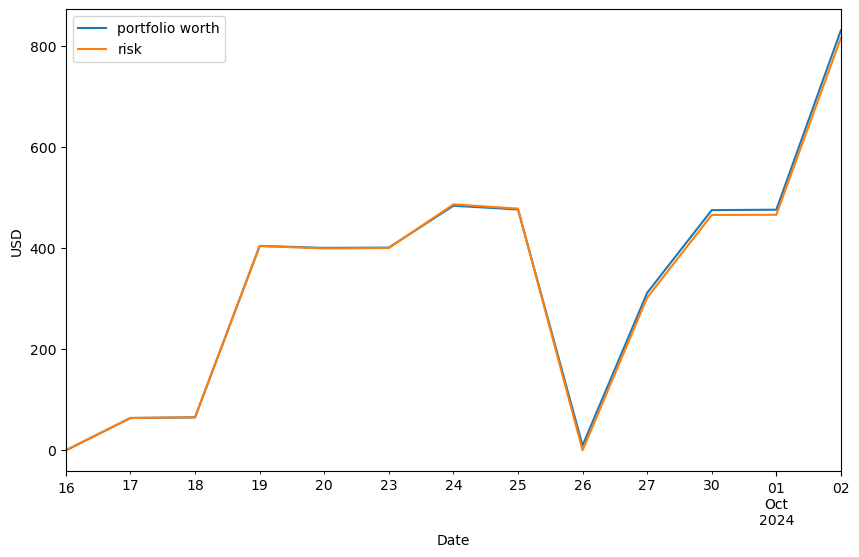

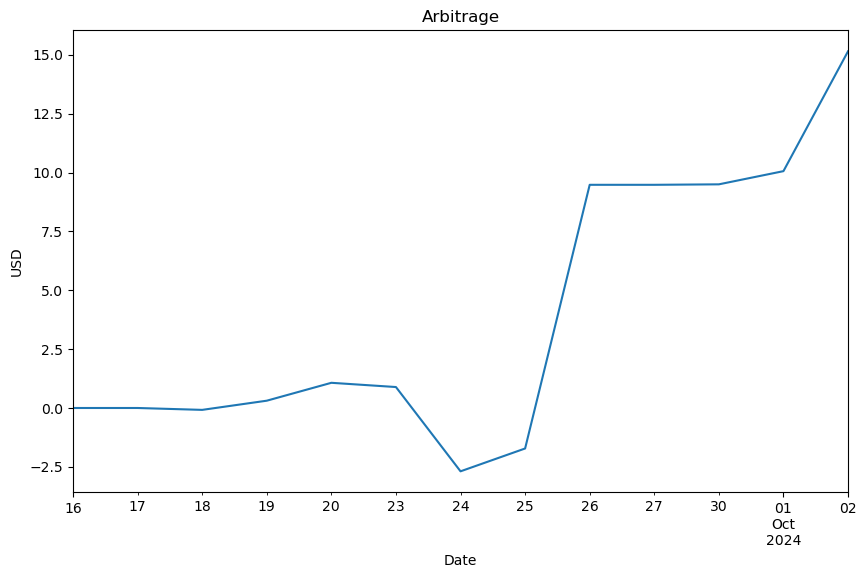

In [91]:
plt.figure(figsize=(10, 6))
Portfolio['portfolio worth'].plot(ylabel='USD',label='portfolio worth')
Portfolio['risking'].plot(ylabel='USD',label='risk')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
Portfolio['Arbitrage'].plot(ylabel='USD',title='Arbitrage')
plt.show()

In [103]:
Final_value = Portfolio['Arbitrage'].iloc[-1]
Final_risk = Portfolio['risking'].iloc[-1]
max_risk = min(Portfolio['Arbitrage'])
print(f"Final profit is {Final_value:.2f} USD")
print(f"Min profit is {max_risk:.2f} USD")
print(f"Risking cost is {Final_risk:.2f}, which makes the profit ratio {Final_value/Final_risk*100:.2f} %")
print(f"Mean return is {(Portfolio['Arbitrage']/Portfolio['portfolio worth']).mean()*100:.2f} % compared to portfolio worth")

Final profit is 15.15 USD
Min profit is -2.69 USD
Risking cost is 815.40, which makes the profit ratio 1.86 %
Mean return is 9.04 % compared to portfolio worth


In [93]:
Portfolio

,APA,DVN,EOG,FANG,MPC,MRO,MTDR,PSX,XOM,risking,stock worth,cash,portfolio worth,Arbitrage
Date,,,,,,,,,,,,,,
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-09-17,-24.389999,39.549999,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,63.939999,79.099998,-15.160000,63.939999,0.000000
2024-09-18,-25.100000,40.180000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,65.280001,80.360001,-15.160000,65.200001,-0.080000
2024-09-19,-25.660000,82.260002,-126.669998,0.000000,0.0,0.00,53.180000,0.000000,-116.160004,403.930004,270.880005,133.360001,404.240005,0.310001
2024-09-20,-25.250000,81.580002,-125.050003,0.000000,0.0,0.00,51.889999,0.000000,-115.459999,399.230003,266.940002,133.360001,400.300003,1.070000
2024-09-23,-25.209999,81.580002,-125.709999,0.000000,0.0,0.00,52.200001,0.000000,-115.330002,400.030003,267.560005,133.360001,400.920006,0.890003
2024-09-24,25.950001,41.849998,-129.399994,0.000000,0.0,0.00,53.439999,0.000000,-235.679993,486.319984,242.479996,241.149994,483.629990,-2.689995
2024-09-25,25.270000,40.730000,-127.470001,0.000000,0.0,0.00,51.580002,0.000000,-232.979996,478.029999,235.160004,241.149994,476.309998,-1.720001
2024-09-26,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,9.480000,9.480000,9.480000
